Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

## ONNX Runtime Object Detection with Yolo model


In this tutorial, you will learn the end-to-end steps from obtaining a Pytorch model, converting to ONNX format, adding pre/post processing steps to the ONNX model using onnxruntime-extensions library and finally plug in and apply inference in a sample mobile android/ios app if applicable.

### 0. Prerequisites

You will need to pip install `onnxruntime onnx onnxruntime_extensions transformers` as the necessary libraries.

```
    pip install onnx onnxruntime onnxruntime_extensions
```

```
    pip install ultralytics
```
To work with Python in Jupyter Notebooks, you must activate an [Anaconda](https://www.anaconda.com/) environment or another Python environment in which you've installed the [Jupyter package](https://pypi.org/project/jupyter/). 

In [1]:
import io
import numpy as np
import onnx
import onnxruntime as ort

###  1. Prepare ONNX Model from Pytorch Yolo model

In [2]:
import ultralytics
from pathlib import Path

Original model: 

In [3]:
def create_onnx_model_from_pytorch(pt_model_name, onnx_model_path):
    """
        Load the model from pytorch and export it to onnx
    """
    
    # Load the pretrained model
    model = ultralytics.YOLO(pt_model_name)
    
    # Export the model to ONNX
    onnx_model_path = model.export(format="onnx")

In [4]:
onnx_model_path = Path('yolov8n.onnx')
if not onnx_model_path.exists():
    print("Creating ONNX model from pytorch model...")
    create_onnx_model_from_pytorch('yolov8n.pt', onnx_model_path)

Check if the output ONNX model is exported successfully.

In [5]:
assert onnx_model_path.exists()

###  2. Add pre and post processing steps to ONNX model

In [6]:
from onnxruntime_extensions.tools.pre_post_processing import *
from onnxruntime_extensions.tools import add_pre_post_processing_to_model as add_ppp

In [7]:
def add_pre_post_processing(input_model_path: Path, output_model_path: str):
    """
    Add pre and post processing to the model
    """
    onnx_opset = 18
    output_format = 'jpg'
    
    model = onnx.load(str(input_model_path.resolve(strict=True)))
    inputs = [create_named_value("image", onnx.TensorProto.UINT8, ["num_bytes"])]

    model_input_shape = model.graph.input[0].type.tensor_type.shape
    assert (model_input_shape.dim[-1].HasField("dim_value") and
            model_input_shape.dim[-2].HasField("dim_value")), "please provide input_shape in the command args."
    w_in = model_input_shape.dim[-1].dim_value
    h_in = model_input_shape.dim[-2].dim_value

    pipeline = PrePostProcessor(inputs, onnx_opset)
    
    # precess steps are responsible for converting any jpg/png image to CHW BGR float32 tensor
    # jpg-->BGR(Image Tensor)-->Resize (scaled Image)-->LetterBox (Fix sized Image)-->(from HWC to)CHW-->float32-->1CHW
    pipeline.add_pre_processing(
        [
            ConvertImageToBGR(),  # jpg/png image to BGR in HWC layout
            # Resize an arbitrary sized image to a fixed size in not_larger policy
            Resize((h_in, w_in), policy='not_larger'),
            LetterBox(target_shape=(h_in, w_in)),  # padding or cropping the image to (h_in, w_in)
            ChannelsLastToChannelsFirst(),  # HWC to CHW
            ImageBytesToFloat(),  # Convert to float in range 0..1
            Unsqueeze([0]),  # add batch, CHW --> 1CHW
        ]
    )
    
    # post-processing steps for NMS(Non-maximum suppression) and drawing bounding boxes
    pipeline.add_post_processing(
        [
            Squeeze([0]), #  Squeeze to remove batch dimension
            Transpose([1, 0]), #  Transpose to (num_boxes, coor+conf)
            SplitOutBoxAndScore(num_classes=80), # Separate bounding box and confidence outputs
            SelectBestBoundingBoxesByNMS(), # Apply NMS to suppress bounding boxes
            (ScaleBoundingBoxes(),  # Scale bounding box coords back to original image
                [
                # A connection from original image to ScaleBoundingBoxes
                # A connection from the resized image to ScaleBoundingBoxes
                # A connection from the LetterBoxed image to ScaleBoundingBoxes
                # We can use the three image to calculate the scale factor and offset.
                # With scale and offset, we can scale the bounding box back to the original image.
                utils.IoMapEntry("ConvertImageToBGR", producer_idx=0, consumer_idx=1),
                utils.IoMapEntry("Resize", producer_idx=0, consumer_idx=2),
                utils.IoMapEntry("LetterBox", producer_idx=0, consumer_idx=3),
            ]),
            # DrawBoundingBoxes on the original image
            # Model imported from pytorch has CENTER_XYWH format
            # two mode for how to color box,
            #   1. colour_by_classes=True, (colour_by_classes), 2. colour_by_classes=False,(colour_by_confidence)
            (DrawBoundingBoxes(mode='CENTER_XYWH', num_classes=80, colour_by_classes=True),
            [
                utils.IoMapEntry("ConvertImageToBGR", producer_idx=0, consumer_idx=0),
                utils.IoMapEntry("ScaleBoundingBoxes", producer_idx=0, consumer_idx=1),
            ]),
            # Encode to jpg/png
            ConvertBGRToImage(image_format=output_format)
        ])
        
    new_model = pipeline.run(model)
    onnx.save_model(new_model, output_model_path)

In [8]:
output_model_path = str(onnx_model_path).replace(".onnx", "_with_pre_post_processing.onnx")
add_pre_post_processing(onnx_model_path, output_model_path)

### 3. Test output ONNX model

In [9]:
from onnxruntime_extensions import get_library_path
from PIL import Image

In [10]:
def test_onnx_model(model_path: str):
    
    providers = ['CPUExecutionProvider']
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED

    # Note: register the custom operators for the image decode/encode pre/post processing provided by onnxruntime-extensions
    # with onnxruntime. if we do not do this we'll get an error on model load about the operators not being found.
    ortext_lib_path = get_library_path()
    so.register_custom_ops_library(ortext_lib_path)
    inference_session = ort.InferenceSession(model_path, providers=providers, sess_options=so)
    
    test_image_path = Path.cwd() / 'testdata' / 'wolves.jpg'
    test_image_bytes = np.fromfile(test_image_path, dtype=np.uint8)
    outputs = inference_session.run(['image_out'], {'image': test_image_bytes})
    upsized_image_bytes = outputs[0]

    original_img = Image.open(io.BytesIO(test_image_bytes))
    updated_img = Image.open(io.BytesIO(upsized_image_bytes))

    new_width, new_height = updated_img.size

    # create a side-by-side image with both.
    # resize the original to the model input size followed by the output size so the processing is more equivalent
    resized_orig_img = original_img.resize((new_width, new_height))

    combined = Image.new('RGB', (new_width * 2, new_height))
    combined.paste(resized_orig_img, (0, 0))
    combined.paste(updated_img, (new_width, 0))
    combined.save('Original picture vs With objects detected in bounding boxes.jpg', format='JPEG')

In [11]:
test_onnx_model(output_model_path)

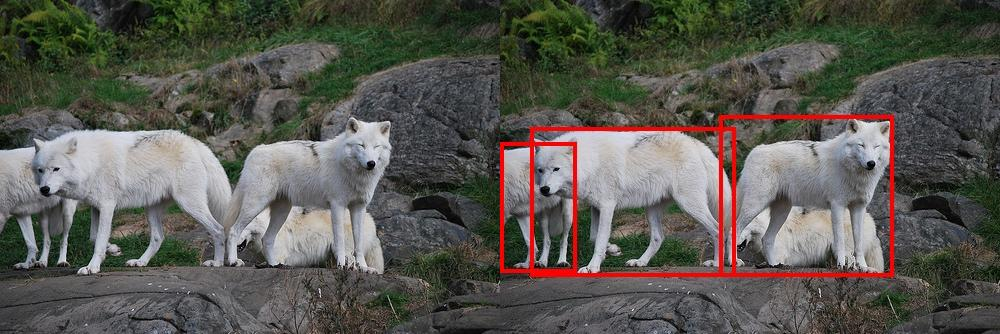

In [12]:
from IPython.display import Image

Image(filename='Original picture vs With objects detected in bounding boxes.jpg', width=750, height=1000)

### 4. Build and run inference with the output model in a mobile application

- **Android**

    **[ORT Object Detection Android Sample application](mobile/examples/object_detection/android)**

    **Note:** You can skip the step about `preparing model` and place the above generated model under `mobile\examples\object_detection\android\app\src\main\res\raw` directory.

    See more information about general prerequisites to build and run an Android application in [README.md/Requirements](mobile/examples/question_answering/android/README.md)


Example code snippet for initalizing ort session and register ort extensions for pre/post processing support:
```kotlin 

   // Initialize Ort Session and register the onnxruntime extensions package that contains the custom operators.
    val sessionOptions: OrtSession.SessionOptions = OrtSession.SessionOptions()
    if (ep.contains("CPU")){
    } else if (ep.contains("NNAPI")) {
        sessionOptions.addNnapi()
    } else if (ep.contains("XNNAPCK")) {
        val po = mapOf<String, String>()
        sessionOptions.addXnnpack(po)
    }
    sessionOptions.setSessionLogLevel(OrtLoggingLevel.ORT_LOGGING_LEVEL_VERBOSE)
    sessionOptions.setSessionLogVerbosityLevel(0)
    sessionOptions.registerCustomOpLibrary(OrtxPackage.getLibraryPath())    
    
    // Read the prepared model from app raw assets folder into bytes
    ortSession = ortEnv.createSession(onnx_model_bytes, sessionOptions)
```

Example code snippet for performing Object Detection task with yolo model in an Android app:
```kotlin

    fun detect(inputStream: InputStream, ortEnv: OrtEnvironment, ortSession: OrtSession) {
        // Step 1: convert image into byte array (raw image bytes)
        val rawImageBytes = inputStream.readBytes()

        // Step 2: get the shape of the byte array and make ort tensor
        val shape = longArrayOf(rawImageBytes.size.toLong())

        val inputTensor = OnnxTensor.createTensor(
            ortEnv,
            ByteBuffer.wrap(rawImageBytes),
            shape,
            OnnxJavaType.UINT8
        )
        inputTensor.use {
            // Step 3: call ort inferenceSession run
            val output = ortSession.run(Collections.singletonMap("image", inputTensor),
                setOf("image_out")
            )

            // Step 4: output analysis
            output.use {
                val rawOutput = (output?.get(0)?.value) as ByteArray
                val outputImageBitmap = byteArrayToBitmap(rawOutput)
            }
        }
    }
```

- **iOS**

    **[ORT Object Detection iOS Sample application](mobile/examples/question_answering/iOS)** (NEED UPDATE)

 ```c
        // Register custom ops
        
        const auto ort_log_level = ORT_LOGGING_LEVEL_INFO;
        auto ort_env = Ort::Env(ort_log_level, "ORTSuperResolution");
        auto session_options = Ort::SessionOptions();
        
        if (RegisterCustomOps(session_options, OrtGetApiBase()) != nullptr) {
            throw std::runtime_error("RegisterCustomOps failed");
        }
        
        // Step 1: Load model
        
        NSString *model_path = [NSBundle.mainBundle pathForResource:@"pytorch_superresolution_with_pre_post_processing_opset18"
                                                             ofType:@"onnx"];
        if (model_path == nullptr) {
            throw std::runtime_error("Failed to get model path");
        }
        
        // Step 2: Create Ort Inference Session
        
        auto sess = Ort::Session(ort_env, [model_path UTF8String], session_options);
        
        // Read input image
        NSString *input_image_path =
        [NSBundle.mainBundle pathForResource:@"wolves" ofType:@"jpg"];
        if (input_image_path == nullptr) {
            throw std::runtime_error("Failed to get image path");
        }
        
        // Step 3: Prepare input tensors and input/output names
        
        NSMutableData *input_data =
        [NSMutableData dataWithContentsOfFile:input_image_path];
        const int64_t input_data_length = input_data.length;
        const auto memoryInfo =
        Ort::MemoryInfo::CreateCpu(OrtDeviceAllocator, OrtMemTypeCPU);
        
        const auto input_tensor = Ort::Value::CreateTensor(memoryInfo, [input_data mutableBytes], input_data_length,
                                                           &input_data_length, 1, ONNX_TENSOR_ELEMENT_DATA_TYPE_UINT8);
        
        constexpr auto input_names = std::array{"image"};
        constexpr auto output_names = std::array{"image_out"};
        
        // Step 4: Call inference session run
        
        const auto outputs = sess.Run(Ort::RunOptions(), input_names.data(),
                                      &input_tensor, 1, output_names.data(), 1);
        if (outputs.size() != 1) {
            throw std::runtime_error("Unexpected number of outputs");
        }
        
        // Step 5: Analyze model outputs
        
        const auto &output_tensor = outputs.front();
        const auto output_type_and_shape_info = output_tensor.GetTensorTypeAndShapeInfo();
        const auto output_shape = output_type_and_shape_info.GetShape();
        
        if (const auto output_element_type =
            output_type_and_shape_info.GetElementType();
            output_element_type != ONNX_TENSOR_ELEMENT_DATA_TYPE_UINT8) {
            throw std::runtime_error("Unexpected output element type");
        }
````

**Note**: Model input/output names, sizes, types may require corresponding adjustment according to specific models using. The above act as sample code for demonstration usage based on yolov8n model.

Also for updating UI in the application, etc. add/modify accordingly based on specific task scenario.